In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
import matplotlib.backends.backend_pdf

In [3]:
cd ..

/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models


In [4]:
from mult_model_fns import *
from folic_acid.folic_acid_mult_model_fns import *

In [5]:
input_data_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [6]:
## GLOBALS

In [7]:
location_ids = pd.read_csv(input_data_path).location_id.unique().tolist()
location_ids

[179,
 163,
 214,
 161,
 165,
 190,
 189,
 196,
 201,
 180,
 15,
 164,
 20,
 202,
 205,
 171,
 11,
 184,
 168,
 6,
 141,
 207,
 181,
 213,
 522]

In [8]:
ages = [1,2,3,4,5]
sexes = [1,2]
ages = [2,3,4,5]

draws = [f'draw_{i}' for i in range(1_000)]
index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [9]:
rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicle = 'wheat flour' 

In [10]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

In [11]:
# calculate relative risk for lack of fortification
# https://vivarium-research.readthedocs.io/en/latest/concept_models/vivarium_conic_lsff/concept_model.html#effect-size-folic-acid
rr_ntds_nofort = format_rrs(lognormal_draws(mu, sigma, seed = 7), location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
179    1.712028
163    1.712028
214    1.712028
161    1.712028
165    1.712028
190    1.712028
189    1.712028
196    1.712028
201    1.712028
180    1.712028
15     1.712028
164    1.712028
20     1.712028
202    1.712028
205    1.712028
171    1.712028
11     1.712028
184    1.712028
168    1.712028
6      1.712028
141    1.712028
207    1.712028
181    1.712028
213    1.712028
522    1.712028
dtype: float64

In [12]:
data = pull_coverage_data(input_data_path, nutrient, vehicle, location_ids, 'wra')

In [13]:
data = create_marginal_uncertainty(data)

In [14]:
data.head()

,Unnamed: 0,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
10,10,179,Ethiopia,NaN,wheat flour,percent of population eating vehicle,na,28.00000,13.776168,42.223832,True,True
12,12,179,Ethiopia,women of reproductive age,wheat flour,percent of population eating industrially prod...,na,20.00000,17.193328,22.806672,False,True
13,13,179,Ethiopia,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,0.00002,0.000010,0.000030,True,True
20,20,163,India,0-24 months,wheat flour,percent of population eating vehicle,na,83.20000,79.500000,86.500000,True,True
21,21,163,India,0-24 months,wheat flour,percent of population eating industrially prod...,na,7.10000,5.600000,9.100000,True,True


In [15]:
alpha, alpha_star = generate_coverage_tables(data, alternative_scenario_coverage_levels, seed = 11)

In [16]:
gets_intervn = prop_gets_intervention_effect(location_ids, year_start=2022, estimation_years = range(2022,2026))

In [18]:
new_coverage = percolate_new_coverage(gets_intervn, alpha, alpha_star)

In [19]:
paf_ntds_nofort = paf_o_r(rr_ntds_nofort, alpha)

In [20]:
paf_ntds_nofort.mean(axis=1)

location_id
179    0.411496
163    0.395933
214    0.366345
161    0.411124
165    0.406799
190    0.390376
189    0.319593
196    0.397693
201    0.321896
180    0.312918
15     0.406492
164    0.398968
20     0.401345
202    0.176536
205    0.411496
171    0.411496
11     0.156945
184    0.387108
168    0.368082
6      0.395746
141    0.370760
207    0.367125
181    0.390240
213    0.328041
522    0.395361
dtype: float64

In [21]:
pif_ntds_nofort = pif_o_r(paf_ntds_nofort, alpha = alpha, alpha_star = new_coverage)

In [22]:
pif_ntds_nofort.head()

draw_0  draw_1  \
location_id year_id age_group_id sex_id coverage_level                   
6           2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_2  draw_3  \
location_id year_id age_group_id sex_id coverage_level                   
6           2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_4  draw_5  \
location_id year_id age_group_id sex_id coverage_level                   
6           2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_6  draw_7  \
location_id year_id age_group_id sex_id coverage_level                   
6           2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_8  draw_9  ...  \
location_id year_id age_group_id sex_id coverage_level                  ...   
6           2022    2            1      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   
                                        0.8                0.0     0.0  ...   
                                 2      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   

                                                        draw_990  draw_991  \
location_id year_id age_group_id sex_id coverage_level                       
6           2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_992  draw_993  \
location_id year_id age_group_id sex_id coverage_level                       
6           2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_994  draw_995  \
location_id year_id age_group_id sex_id coverage_level                       
6           2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                    

In [24]:
dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)

In [25]:
dalys_averted = calc_dalys_averted(dalys, pif_ntds_nofort)

In [26]:
dalys_averted_u5 = dalys_averted.reset_index().groupby(['location_id','year_id','coverage_level']).sum()[draws]

In [27]:
dalys_averted_u5.head()

draw_0       draw_1       draw_2  \
location_id year_id coverage_level                                          
6           2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2             2840.531870  2423.670445  2918.228682   
                    0.5             7101.329676  6059.176113  7295.571705   

                                         draw_3       draw_4       draw_5  \
location_id year_id coverage_level                                          
6           2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2             3849.306474  3701.716838  3002.294382   
                    0.5             9623.266185  9254.292094  7505.735956   

                                         draw_6       draw_7       draw_8  \
location_id year_id coverage_level                                          
6           2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2             2910.098762  1150.703439  3028.945124   
                    0.5             7275.246905  2876.758597  7572.362811   

                                         draw_9  ...     draw_990  \
location_id year_id coverage_level               ...                
6           2022    0.2                0.000000  ...     0.000000   
                    0.5                0.000000  ...     0.000000   
                    0.8                0.000000  ...     0.000000   
            2023    0.2             2878.898172  ...  3392.174269   
                    0.5             7197.245431  ...  8480.435673   

                                       draw_991      draw_992      draw_993  \
location_id year_id coverage_level                                            
6           2022    0.2                0.000000      0.000000      0.000000   
                    0.5                0.000000      0.000000      0.000000   
                    0.8                0.000000      0.000000      0.000000   
            2023    0.2             3322.805292   4352.263509   5031.427059   
                    0.5             8307.013230  10880.658773  12578.567648   

                                       draw_994     draw_995     draw_996  \
location_id year_id coverage_level                                          
6           2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2             2487.940245  2777.306351  2957.134133   
                    0.5             6219.850613  6943.265878  7392.835333   

                                       draw_997     draw_998     draw_999  
location_id year_id coverage_level                                         
6           2022    0.2                0.000000     0.000000     0.000000  
                    0.5                0.000000     0.000000     0.000000  
                    0.8                0.000000     0.000000     0.000000  
            2023    0.2             2343.941232  2427.857069  2337.238644  
                    0.5             5859.853079  6069.642671  5843.096611  

[5 rows x 1000 columns]

In [28]:
dalys_averted_path = '/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models/folic_acid/tier1_2_3_4_5_wheat_flour_dalys_averted_folic_acid_04_01_2021.csv.csv'
dalys_averted_u5.to_csv(dalys_averted_path)

In [29]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p025'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.025, axis=1)
dalys_averted_u5['p975'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.975, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p025','p975']]

dalys_averted_u5 = dalys_averted_u5.reset_index()

In [30]:
## add rates
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p025_dalys_per_100_000py'] = dalys_averted_u5.p025 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p975_dalys_per_100_000py'] = dalys_averted_u5.p975 / dalys_averted_u5.population * 100_000

In [31]:
dalys_averted_u5.head()

,location_id,year_id,coverage_level,mean_value,p025,p975,population,mean_dalys_per_100_000py,p025_dalys_per_100_000py,p975_dalys_per_100_000py
0,6,2022,0.2,0.000000,0.000000,0.000000,8.149086e+07,0.000000,0.000000,0.000000
1,6,2022,0.5,0.000000,0.000000,0.000000,8.149086e+07,0.000000,0.000000,0.000000
2,6,2022,0.8,0.000000,0.000000,0.000000,8.149086e+07,0.000000,0.000000,0.000000
3,6,2023,0.2,2563.396590,1162.172466,4283.245448,8.149086e+07,3.145625,1.426138,5.256105
4,6,2023,0.5,6408.491475,2905.431165,10708.113619,8.149086e+07,7.864062,3.565346,13.140263


# viz results

In [32]:
# coverage_level_dict = {0.2:'low',0.5:'medium',0.8:'high'}
# dalys_averted_u5.coverage_level = dalys_averted_u5.coverage_level.map(coverage_level_dict)

/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


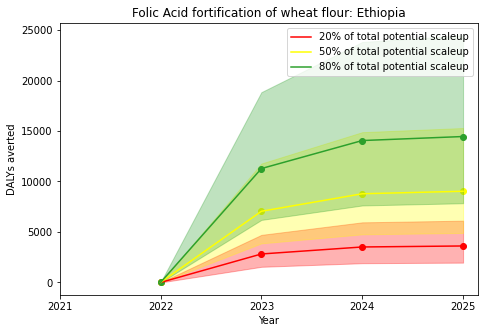

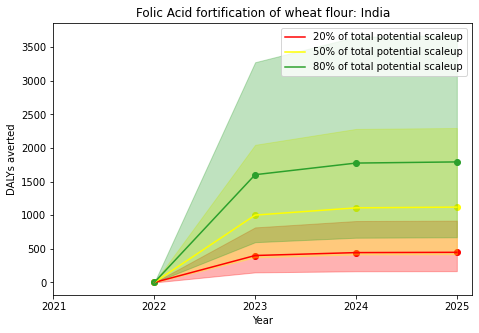

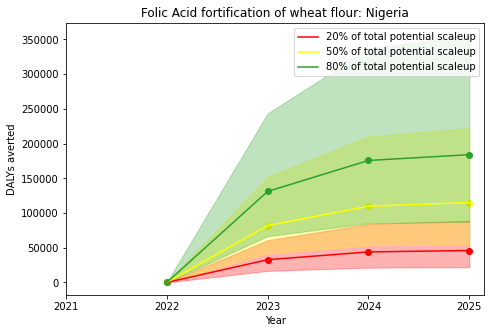

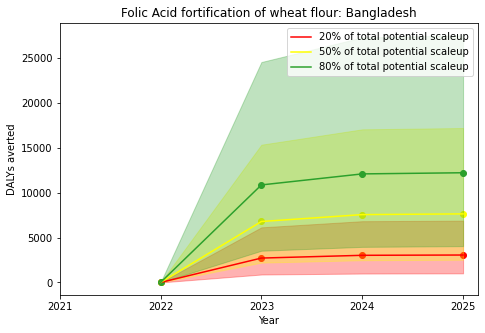

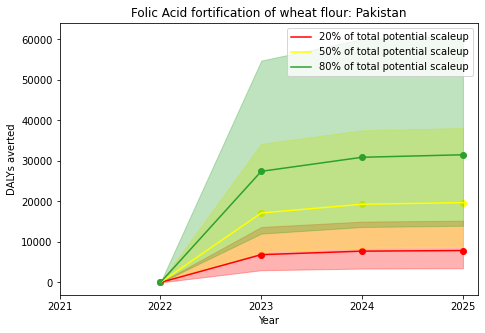

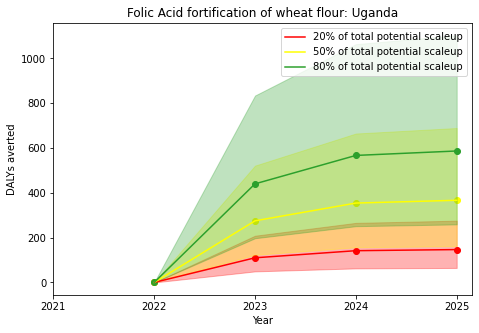

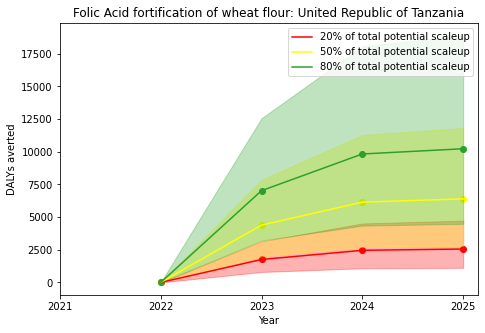

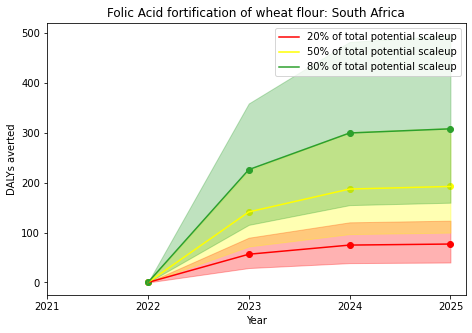

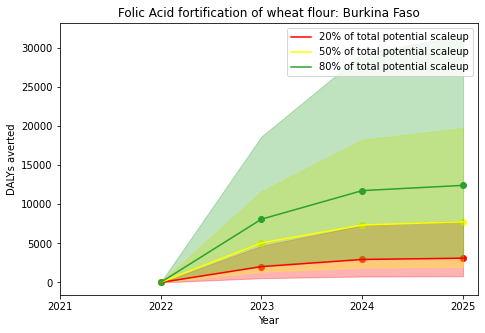

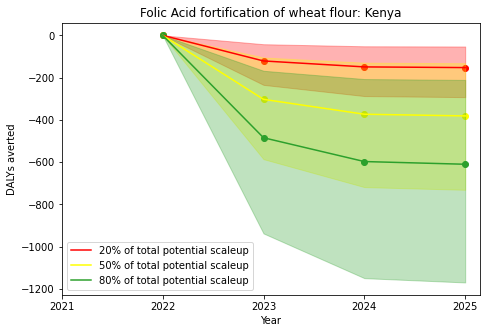

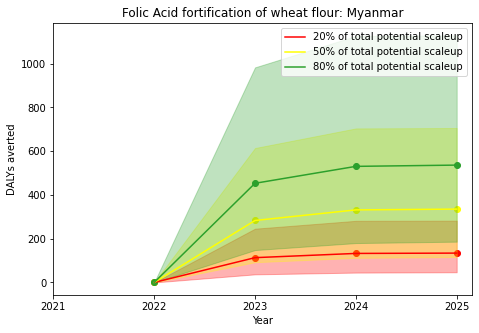

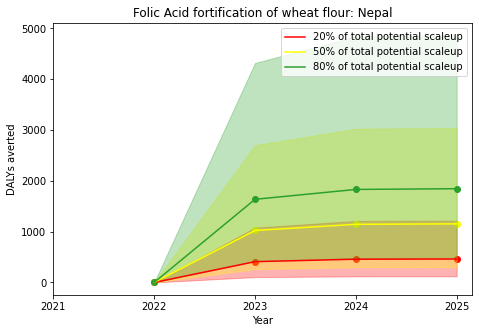

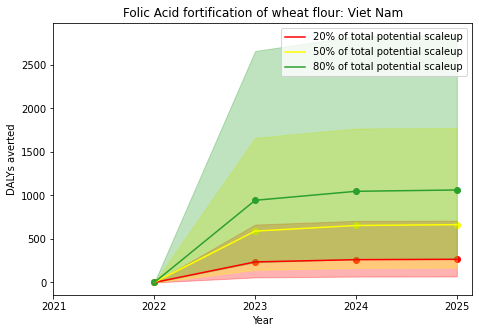

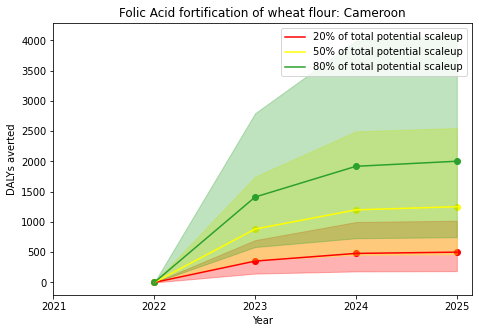

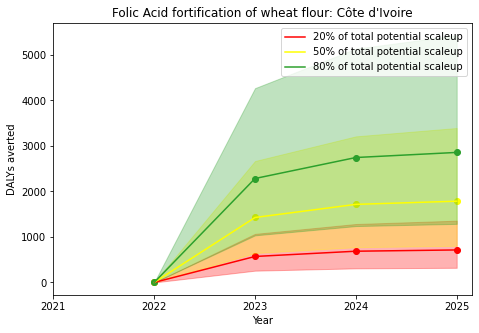

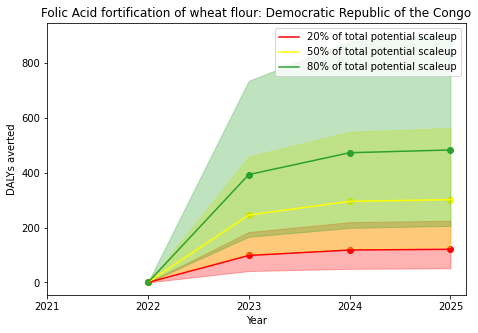

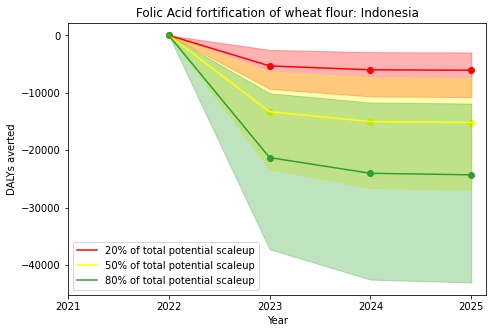

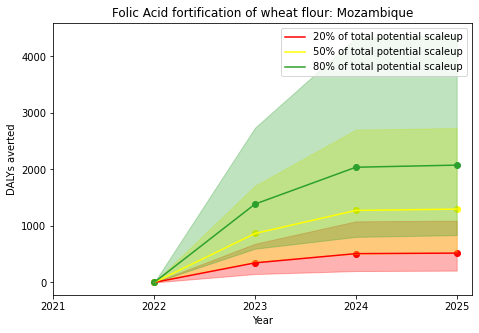

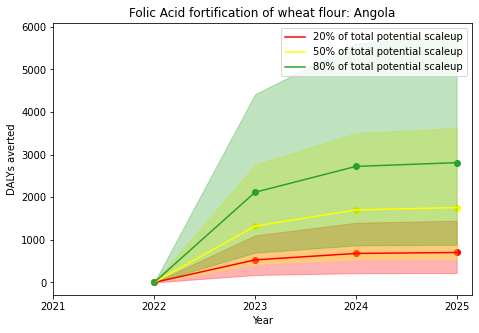

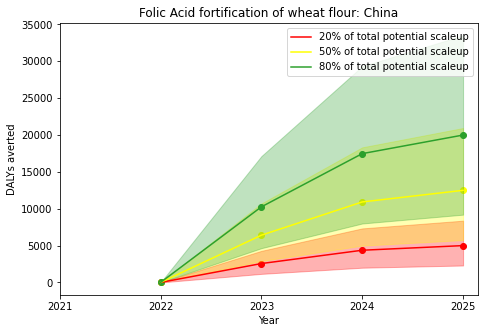

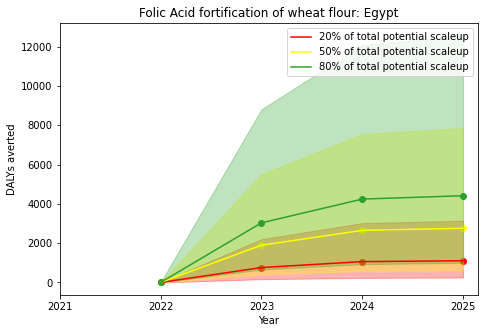

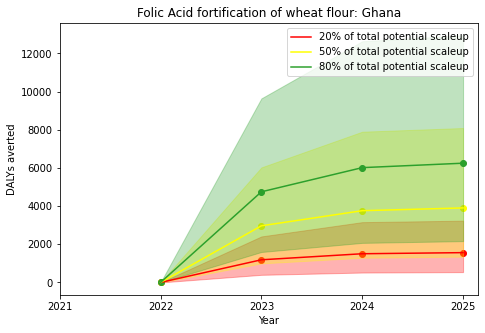

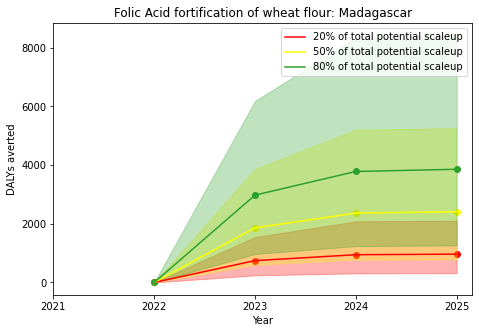

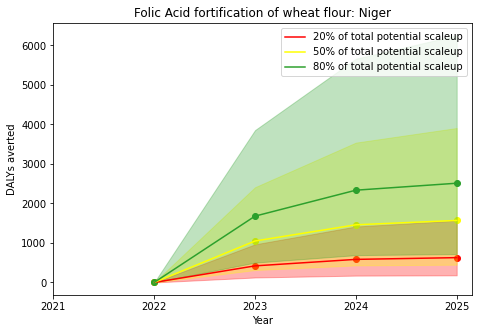

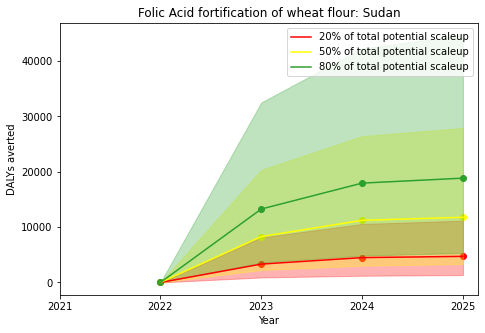

In [33]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}
    
    for loc in location_ids: #TODO: fix/requires global 'location_ids'
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{int(level*100)}% of total potential scaleup')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification of {vehicle}: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


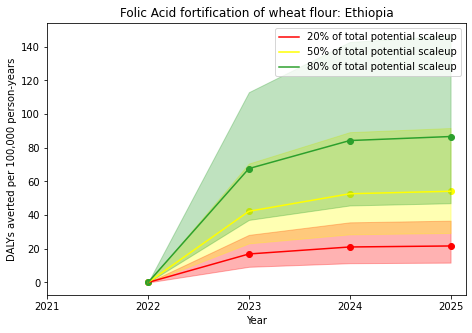

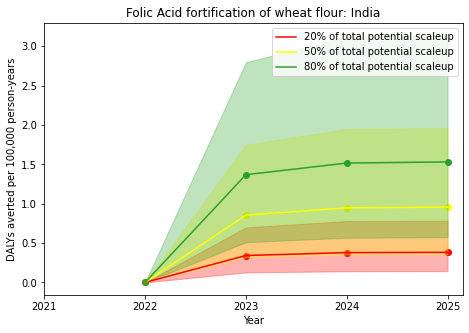

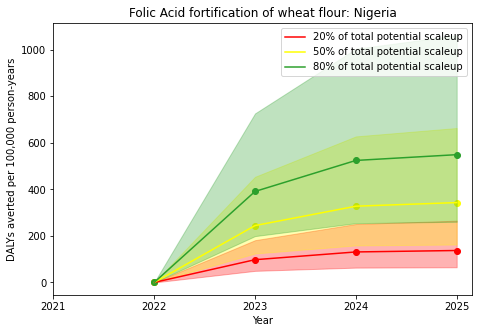

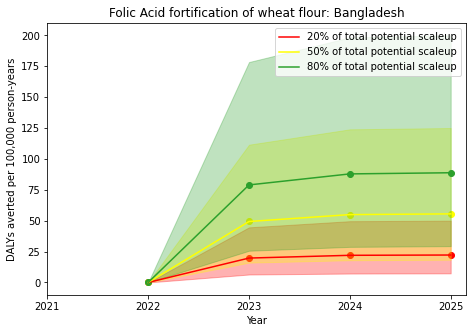

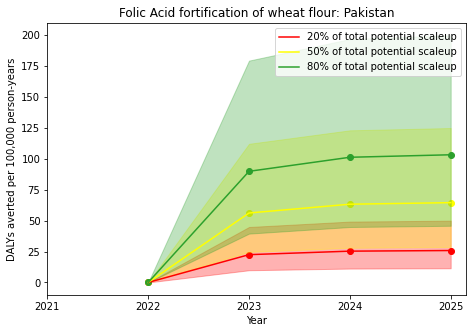

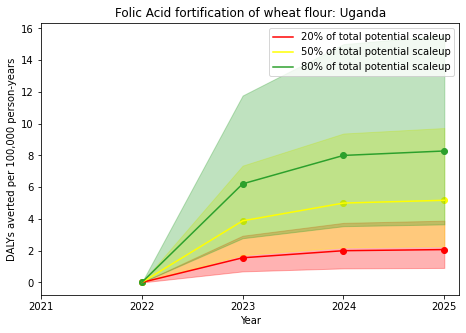

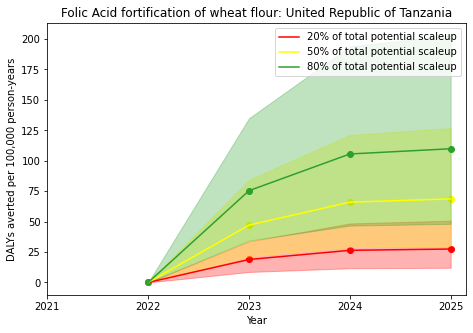

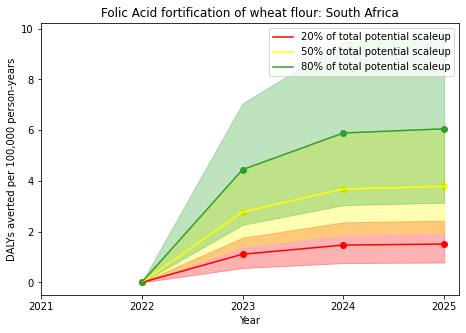

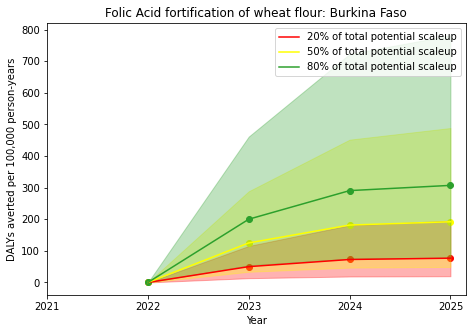

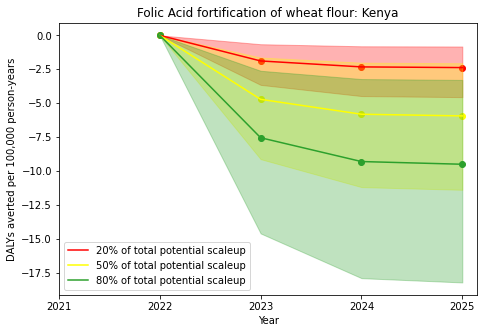

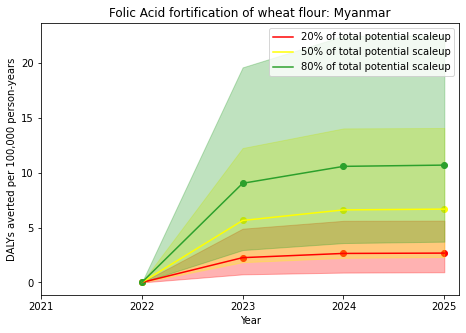

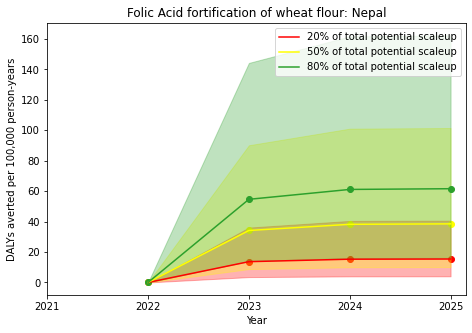

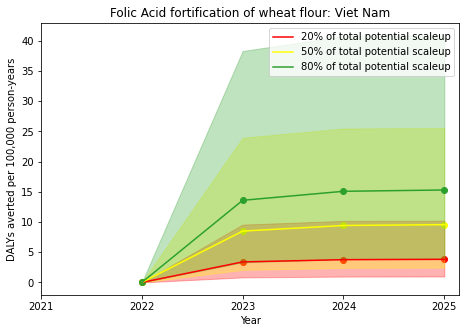

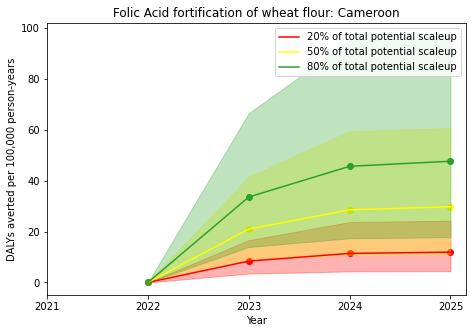

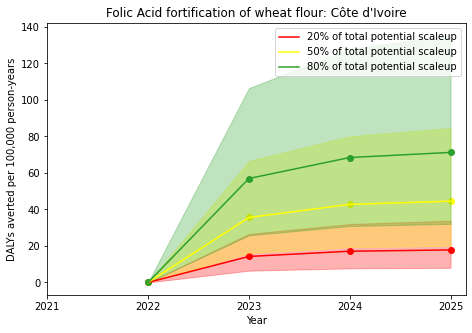

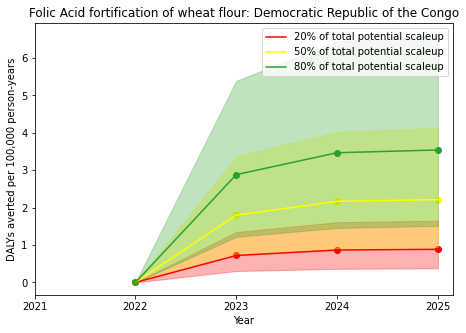

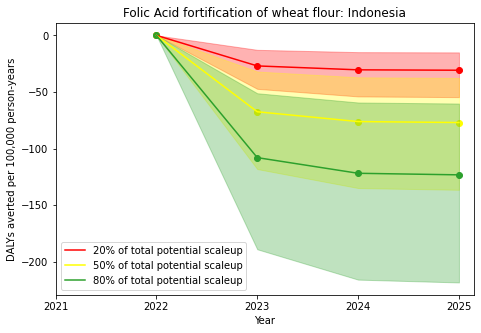

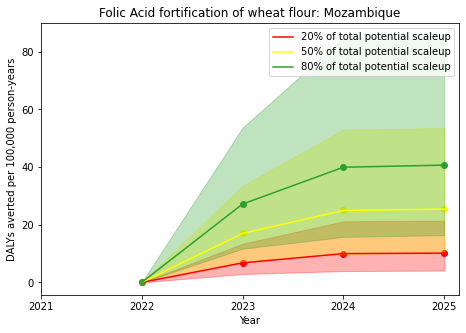

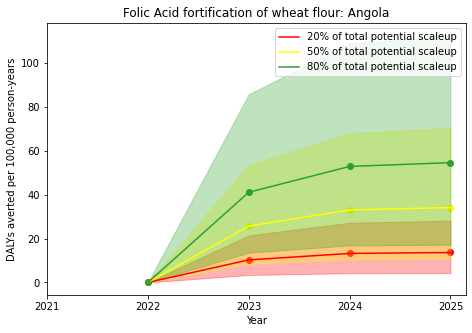

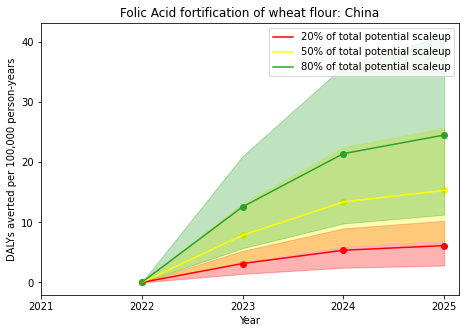

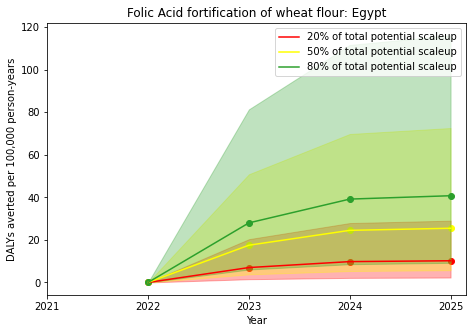

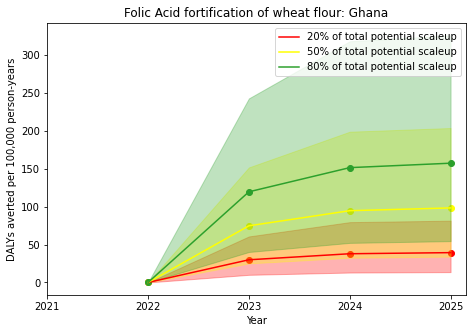

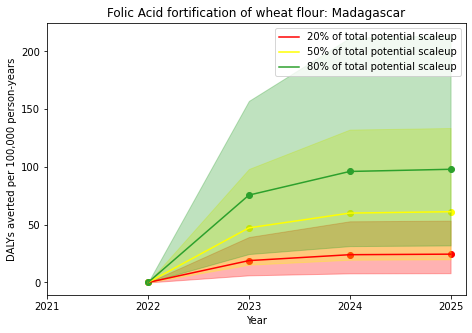

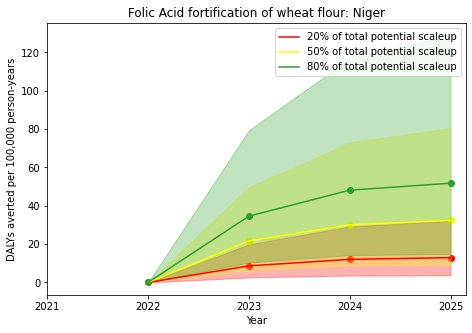

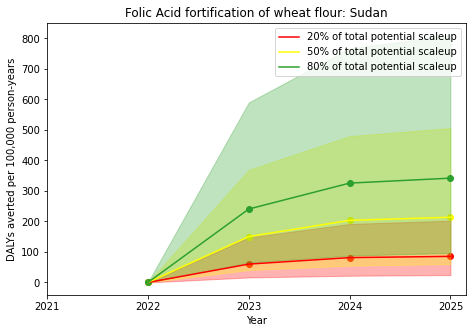

In [34]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}    
    for loc in location_ids:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{int(level*100)}% of total potential scaleup')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification of {vehicle}: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


In [33]:
# def plot_dalys_averted(save_path):
#     pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
#     location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
#               'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

#     for level in alternative_scenario_coverage_levels:
#         fig, ax = plt.subplots(figsize=(7.5, 5))
#         for i in range(len(location_ids)):
#             loc = location_ids[i]
            
#             plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[i])
#             plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[i], label = location_names[loc])
#             plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[i])
#             plt.ylabel('DALYs averted')
#             plt.xlabel('Year')
#             plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
#             plt.legend()
#             plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
#         pdf.savefig(fig)
    
#     plt.show()
#     pdf.close()

# save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
# plot_dalys_averted(save_path)


In [34]:
# def plot_dalys_averted_rate(save_path):
#     pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
#     location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
#               'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

#     for level in alternative_scenario_coverage_levels:
#         fig, ax = plt.subplots(figsize=(7.5, 5))
#         for i in range(len(location_ids)):
#             loc = location_ids[i]

#             plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[i])
#             plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[i], label = location_names[loc])
#             plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[i])
#             plt.ylabel('DALYs averted per 100,000 person-years')
#             plt.xlabel('Year')
#             plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
#             plt.legend()
#             plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
#         pdf.savefig(fig)

#     plt.show()
#     pdf.close()

# save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
# plot_dalys_averted_rate(save_path)

In [35]:
# this is why kenya is negative
inputs = pd.read_csv(input_data_path)

inputs[(inputs.location_name=="Kenya") & (inputs.nutrient=="folic acid")]



,Unnamed: 0,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
123,123,180,Kenya,NaN,maize flour,percent of population eating fortified vehicle,folic acid,0.000000,0.00000,0.000000,True,True
132,132,180,Kenya,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,34.703333,15.25348,54.153186,True,True


In [36]:
inputs[(inputs.location_name=="Kenya") & (inputs.vehicle.isin(['maize flour','wheat flour'])) & (inputs.value_description=="percent of population eating industrially produced vehicle")]

,Unnamed: 0,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
122,122,180,Kenya,total population,maize flour,percent of population eating industrially prod...,na,36.67,17.221861,56.118139,True,True
131,131,180,Kenya,total population,wheat flour,percent of population eating industrially prod...,na,30.95,13.603743,48.296257,True,True
